In [1]:
import numpy as np
import keras
import scipy.io as sio
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
import matplotlib.pyplot as plt 
from keras import layers
#from keras.models import Sequential
from keras.models import model_from_json
from livelossplot.keras import PlotLossesCallback
from IPython.display import clear_output
from keras.utils.vis_utils import plot_model
#from sklearn import preprocessing
#import math

In [2]:
keras.backend.clear_session()

In [3]:
filename = 'MarmousiModel2.mat'
marmousi_cube = sio.loadmat(filename)

### Carregar dados e cubos de Sísmica e Impedância

In [4]:
VP = marmousi_cube['Vp']
#VS = marmousi_cube['Vs']
#IS = marmousi_cube['IS']
pimpedance = marmousi_cube['IP']
seismic = marmousi_cube['seismic']

WAVELET = marmousi_cube['wavelet']

### Parameters 

In [5]:
n_traces = pimpedance.shape[1]

train_wells_loc = np.arange(0,n_traces,135)
all_wells_loc = np.arange(n_traces)

wells_loc = np.array(list(set(all_wells_loc) - set(train_wells_loc)))
valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(wells_loc,
                                                                      test_size=0.9,
                                                                      train_size=0.1,
                                                                      shuffle=True)
BATCH_SIZE = 10
noise_dim = 2800
IMG_SHAPE = (2800,1)

### Normalizar Sismica

In [6]:
seismic_norm = seismic.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
seismic_norm = seismic_norm.reshape(seismic.shape)
#seismic_norm = seismic

In [7]:
pimpedance_norm = pimpedance.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
pimpedance = pimpedance_norm.reshape(pimpedance.shape)
#seismic_norm = seismic

### Visualizar estatísticas

In [8]:
'''data_info = pd.DataFrame(zip(seismic_norm.flatten(),
                             pimpedance.flatten()),
                         columns=['Seismic CL Stats','PImp CL Stats'])
data_info.describe()'''

"data_info = pd.DataFrame(zip(seismic_norm.flatten(),\n                             pimpedance.flatten()),\n                         columns=['Seismic CL Stats','PImp CL Stats'])\ndata_info.describe()"

### Preparar os Dados

In [9]:
X_train = np.transpose(seismic_norm[:,train_wells_loc])
Y_train = np.transpose(pimpedance[:-1,train_wells_loc])
X_train = np.expand_dims(X_train,axis=(2))
Y_train = np.expand_dims(Y_train,axis=(2))

X_valid = np.transpose(seismic_norm[:,valid_wells_loc])
Y_valid = np.transpose(pimpedance[:-1,valid_wells_loc])
X_valid = np.expand_dims(X_valid,axis=(2))
Y_valid = np.expand_dims(Y_valid,axis=(2))

X_test = np.transpose(seismic_norm)
Y_test = np.transpose(pimpedance[:-1,:])
X_test = np.expand_dims(X_test,axis=(2))
Y_test = np.expand_dims(Y_test,axis=(2))

UNLABED_SEISMIC = np.transpose(seismic_norm[:,unlabed_wells_loc])
UNLABED_SEISMIC = np.expand_dims(UNLABED_SEISMIC,axis=(2))

In [10]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

print('     IP (Y_valid) shape: ',Y_valid.shape)
print('seismic (X_valid) shape: ',X_valid.shape)

print('     IP (Y_test) shape: ',Y_test.shape)
print('seismic (X_test) shape: ',X_test.shape)


     IP (Y_train) shape:  (21, 700, 1)
seismic (X_train) shape:  (21, 700, 1)
     IP (Y_valid) shape:  (270, 700, 1)
seismic (X_valid) shape:  (270, 700, 1)
     IP (Y_test) shape:  (2721, 700, 1)
seismic (X_test) shape:  (2721, 700, 1)


### Visualizar Dados

Text(0.5, 1.0, 'Output P-Impedance Test - Ground True')

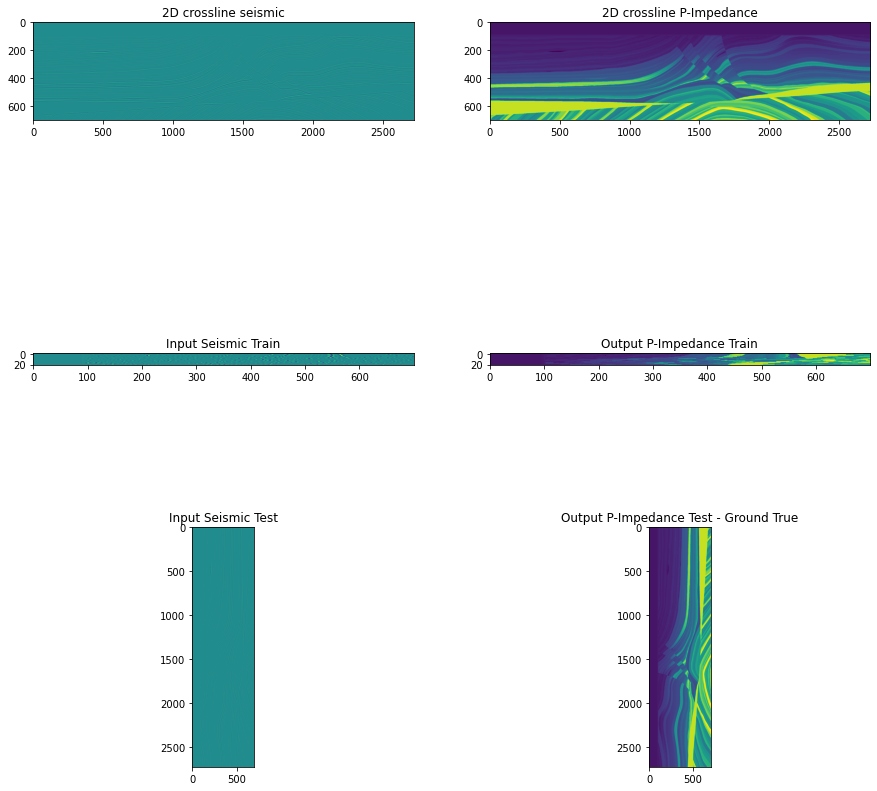

In [11]:
fig1, axes1 = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

axes1[0,0].imshow(seismic)
axes1[0,0].set_title("2D crossline seismic")

axes1[0,1].imshow(pimpedance)
axes1[0,1].set_title("2D crossline P-Impedance")

axes1[1,0].imshow(X_train[:,:,0])
axes1[1,0].set_title("Input Seismic Train")

axes1[1,1].imshow(Y_train[:,:,0])
axes1[1,1].set_title("Output P-Impedance Train")

axes1[2,0].imshow(X_test[:,:,0])
axes1[2,0].set_title("Input Seismic Test")
axes1[2,1].imshow(Y_test[:,:,0])
axes1[2,1].set_title("Output P-Impedance Test - Ground True")

## Criação e Configuração da Rede

### Carregar Modelo Forward

In [13]:
# load json and create model
json_file = open('forward_model/modelnorm_1d.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
forward_model = model_from_json(loaded_model_json)
# load weights into new model
forward_model.load_weights("forward_model/modelnorm_1d.h5")
print("Loaded forward model from disk")


Loaded forward model from disk


In [15]:
test_forward = False
if test_forward:
    predict = forward_model(Y_test[:8000,:,:])
    predict = np.transpose(predict[:,:,0].numpy())

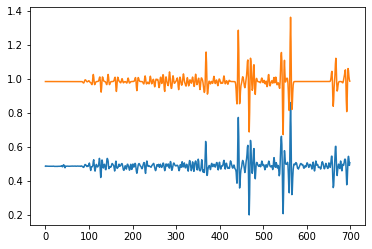

(1, 700, 2721)

In [27]:
if test_forward:
    trace_id = np.random.randint(predict.shape[1])
    plt.plot(predict[:,trace_id])
    plt.plot(X_test[trace_id,:,0]+0.5)
    plt.show()

### Create the generator


In [ ]:
def ResBlock(inputRB):
    RB0 = layers.Conv1D(filters=16,kernel_size=300,padding='same')(inputRB)
    RB = layers.BatchNormalization()(RB0)
    RB = layers.ReLU()(RB)
    RB = layers.Conv1D(filters=16,kernel_size=3,padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,inputRB])
    RB = layers.ReLU()(RB)
    return (RB)

In [ ]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,1))

    GEN = layers.Conv1D(filters=16,kernel_size=300,padding='same')(noise)
    GEN = layers.BatchNormalization()(GEN)
    GEN = layers.ReLU()(GEN)
    
    GEN = ResBlock(GEN)
    GEN = ResBlock(GEN)
    GEN = ResBlock(GEN)
    
    GEN = layers.Conv1D(filters=1,kernel_size=3,padding='same')(GEN)

    GENmodel = keras.models.Model(inputs=noise,outputs=GEN)
    return GENmodel

### Create the discriminator (the critic in the original WGAN)

In [ ]:
def PyramidPoolingModule(inputASSP):
    r1 = layers.Conv1D(filters=32,kernel_size=3,padding='same',dilation_rate=1)(inputASSP)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.ReLU()(r1)
    r2 = layers.Conv1D(filters=32,kernel_size=3,padding='same',dilation_rate=3)(inputASSP)
    r2 = layers.BatchNormalization()(r2)
    r2 = layers.ReLU()(r2)
    r3 = layers.Conv1D(filters=32,kernel_size=3,padding='same',dilation_rate=5)(inputASSP)
    r3 = layers.BatchNormalization()(r3)
    r3 = layers.ReLU()(r3)
    r4 = layers.Conv1D(filters=32,kernel_size=3,padding='same',dilation_rate=7)(inputASSP)
    r4 = layers.BatchNormalization()(r4)
    r4 = layers.ReLU()(r4)
    assp = layers.concatenate([r1,r2,r3,r4])
    assp = layers.Conv1D(filters=64,kernel_size=3,padding='same',strides=2)(assp)
    return assp

def EncoderBlock(inputEncB):
    ENCN = layers.Conv1D(filters=16,kernel_size=300,padding='same')(inputEncB)
    ENCN = layers.ReLU()(ENCN)
    ENCN = layers.Conv1D(filters=16,kernel_size=3,padding='same')(ENCN)
    ENCN = layers.Add()([ENCN, inputEncB])
    ENCN = layers.MaxPooling1D(pool_size=1,strides=2)(ENCN)
    ENCN = layers.ReLU()(ENCN)
    return ENCN

def Encoder(inputEncoder):
    ENC = layers.Conv1D(filters=16,kernel_size=300,padding='same',strides=2)(inputEncoder)
    ENC = layers.LeakyReLU()(ENC)
    ENC = layers.MaxPooling1D(pool_size=1,strides=2)(ENC)
    ENC = EncoderBlock(ENC)
    ENC = EncoderBlock(ENC)
    ENC = EncoderBlock(ENC)
    return  ENC

def get_discriminator_model():       
        input_disc = layers.Input(shape=(700,1))        
        enc_out = Encoder(input_disc)
        assp_out = PyramidPoolingModule(enc_out)
        fc_out = layers.Dense(256,kernel_initializer=tf.keras.initializers.HeNormal())(assp_out)
        lkr_out = layers.LeakyReLU()(fc_out)
        fc2_outFlatten = layers.Flatten()(lkr_out)
        fc2_out = layers.Dense(1,
                               kernel_initializer=tf.keras.initializers.HeNormal(),
                               #activation=keras.activations.sigmoid
                              )(fc2_outFlatten)
        
        DISCmodel = keras.models.Model(inputs=input_disc,outputs=fc2_out)
        return DISCmodel

### Create the WGAN-GP model

In [ ]:
little_amout = 1e-8

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
        alpha_weight = 1000,
        beta_weight = 500
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.alpha_weight = alpha_weight
        self.beta_weight = beta_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, imp_loss_fn, seis_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.imp_loss_fn = imp_loss_fn
        self.seis_loss_fn = seis_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)
       
        #2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        #3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        noises_input,real_images = data
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = noises_input
        
        for i in range(self.d_steps):
            # Get the latent vector

            with tf.GradientTape() as tape:
                
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)

                real_logits = self.discriminator(real_images, training=True)

                # discriminator loss
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # gradient penalty:
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                
                d_loss = d_cost + gp * self.gp_weight + little_amout

            
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        #unlabed seismic mini batch:
        unlabed_wells_loc = np.arange(UNLABED_SEISMIC.shape[1])
        np.random.shuffle(unlabed_wells_loc)
        unlabed_batch_idxs = unlabed_wells_loc[0:BATCH_SIZE]
        unlabed_batch = UNLABED_SEISMIC[unlabed_batch_idxs,:,:]
        
        with tf.GradientTape() as tape:
            
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            
            #Generator loss
            g_cost = self.g_loss_fn(gen_img_logits)
            
            #Impedance loss
            imp_loss = self.imp_loss_fn(generated_images, real_images)
            
            #Seismic loss:
            fake_seis_unlabed = forward_model(self.generator(unlabed_batch,training=False))
            seis_cost = self.seis_loss_fn(fake_seis_unlabed,unlabed_batch)
            
            g_loss = g_cost + self.alpha_weight * imp_loss + self.beta_weight * seis_cost+little_amout
            
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss,"imp_loss":(self.alpha_weight * imp_loss),"seis_loss":(self.beta_weight * seis_cost)}

### CallBack

In [ ]:
checkp_callback = keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                             monitor='imp_loss',
                                             verbose=2,
                                             save_best_only=True,
                                             mode='min')

earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='imp_loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=2, 
            patience=600)

nan_callback = tf.keras.callbacks.TerminateOnNaN()

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.d_losses = []
        self.g_losses = []
        self.imp_losses = []
        self.seis_losses =[]
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.d_losses.append(logs.get('d_loss'))
        self.g_losses.append(logs.get('g_loss'))
        self.imp_losses.append(logs.get('imp_loss'))
        self.seis_losses.append(logs.get('seis_loss'))
        self.i += 1
        
        clear_output(wait=True) 
        if self.i>50:
            plt.plot(self.x[-100:], self.d_losses[-100:], label="d_loss")
            plt.plot(self.x[-100:], self.g_losses[-100:], label="g_loss")
            plt.plot(self.x[-100:], self.imp_losses[-100:], label="imp_loss")
            plt.plot(self.x[-100:], self.seis_losses[-100:], label="seis_loss")
        else:
            plt.plot(self.x, self.d_losses, label="d_loss")
            plt.plot(self.x, self.g_losses, label="g_loss")
            plt.plot(self.x, self.imp_losses, label="imp_loss")
            plt.plot(self.x, self.seis_losses, label="seis_loss")
        plt.legend()
        plt.show();
        
plot_callback = PlotLosses()

### Train the end-to-end model


In [ ]:
g_model = get_generator_model()
#g_model.summary()
#plot_model(g_model, show_shapes=True, show_layer_names=False)
d_model = get_discriminator_model()
#d_model.summary()
#plot_model(d_model, show_shapes=True, show_layer_names=False)
plot_losses = PlotLosses()

# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
discriminator_optimizer = keras.optimizers.Adam(learning_rate = 0.0003)
# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def impedance_loss(fake_imp,real_imp):
    imp_mse = tf.keras.metrics.mean_squared_error(real_imp, fake_imp)
    #imp_mse = tf.reduce_mean(tf.square(real_imp - fake_imp))
    return imp_mse

def seismic_loss(fake_seis,real_seis):
    #fake_seis = forward_model(imp_gen)
    #seis_loss = tf.reduce_mean(tf.square(real_seis - fake_seis))
    seis_loss = tf.keras.metrics.mean_squared_error(real_seis, fake_seis)
    return seis_loss

# Set the number of epochs for trainining.
epochs = 300

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
    alpha_weight = 1000,
    beta_weight = 500,
    gp_weight = 10
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    imp_loss_fn = impedance_loss,
    seis_loss_fn = seismic_loss
)

In [ ]:
# Start training the model.
wgan.fit(X_train,Y_train,
         shuffle=True,
         batch_size=BATCH_SIZE, 
         epochs=epochs, 
         verbose = 1,
         #callbacks=[checkp_callback]
        )

In [ ]:
X_predict = wgan.generator(X_test[0:7000,:,:])
X_predict = np.transpose(X_predict[:,:,0])

In [ ]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(50,15))
axes1[0].imshow(X_predict)
axes1[1].imshow(np.transpose(Y_test[0:7000,:,0]))


In [ ]:
trace_id = np.random.randint(X_predict.shape[1])
plt.plot(X_predict[:,trace_id])

plt.plot(Y_test[trace_id,:,0])
plt.legend(('predicted','target'))

In [ ]:
'''# serialize model to JSON
model_json = wgan.to_json()
with open("models/model0.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
wgan.save_weights("model/model0.h5")
print("Saved model to disk")
'''
''